In [1]:
#package imports
import os
import numpy as np
import pandas as pd 
import re
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import qgrid

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import set_random_seed

print(tf.VERSION)
print(tf.keras.__version__)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import model_selection


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.utils import plot_model

import h5py
from keras.models import load_model

# Pre-defined imports
import sys
sys.path.append('../')

from TextLabeller import get_sentences



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2985719364609053523
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6626719826
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6872682435775130309
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
1.13.1
2.2.4-tf


Using TensorFlow backend.


In [2]:

max_features = 5000 #number of words to consider as features 

def get_sequences(max_features, data):
    #tokenize and put into sequences
    tokenizer = Tokenizer(num_words=max_features, split=' ')
    # print(tokenizer)
    tokenizer.fit_on_texts(data['text'].values)
    # print(data['text'].values)
    sequences = tokenizer.texts_to_sequences(data['text'].values)
    sequences = pad_sequences(sequences) #maxlen = len of longest sequence/words in a sentence
    return sequences


def create_lstm_model():
    #Create Model
    model = tf.keras.Sequential()
    model.add(layers.Embedding(max_features, embedding_dim, input_length = sequences.shape[1])) #(size of vocabulary, size of embedding vecotr, length of input (i.e. no. steps/words in each sample))
    model.add(layers.SpatialDropout1D(0.4)) # fraction of the input units to drop

#   model.add(LSTM(units, dropout = 0.2, recurrent_dropout =0.1, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001))) #return_sequences=True))    
#   model.add(LSTM(units, dropout = 0.2, recurrent_dropout =0.2)) #return_sequences=True))
    model.add(layers.CuDNNLSTM(units)) # for GPU
#     model.add(layers.LSTM(units))
    
    model.add(layers.Dense(100, input_dim =2, activation = 'relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(2,activation='softmax')) #no. of classes is 2, softmax is the same as the sigmoid function.
                                            # higher no. of classes, then softmax is used for multiclass classification
#     plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    #Compile model
#     model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
#               loss=tf.keras.losses.categorical_crossentropy,
#               metrics=[tf.keras.metrics.categorical_accuracy]) #metrics=['accuracy'] change when using k-folds
    
   
    #Adamax, RMSprop, Adam
    
    
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop',metrics = ['accuracy']) 
    ## calculate the loss function, [calculate gradient and do back-propagation].
    # one-hot encoded, use "categorical_crossentropy". Otherwise if targets are integers, "sparse_categorical_crossentropy".
    # In order to convert integer targets into categorical targets, you can use the Keras utility "to_categorical"
    # when using "sparse_categorical_crossentropy"--> ValueError: Error when checking target: expected dense_3 to have shape (1,) but got array with shape (2,)
    print(model.summary())
 
    return model


In [3]:

# filepath='../results/data_generated1/labelled_processed_text.csv'

METRIC = "jaccard"

labelled_real=f'../analysis_jaccard/{METRIC}_labelled_real_text.csv'
labelled_fake=f'../analysis_jaccard/{METRIC}_labelled_fake_text.csv'

real_data = pd.read_csv(labelled_real)
fake_data = pd.read_csv(labelled_fake)

# real_data['text'] = real_data['text'].astype('str').str.lower()
# mask = (real_data['text'].str.len() >= 20)
# real_data = real_data[mask]

# fake_data['text'] = fake_data['text'].astype('str')
# mask = (fake_data['text'].str.len() >= 20)
# fake_data = fake_data[mask]

print(fake_data.head(10))

# fake_data = fake_data[len(real_data['text'].split()) >= 20]

combined_data = real_data.append(fake_data)

y = combined_data['label'].values

# file_dir = os.path.dirname(os.path.realpath('__file__'))
# filename = os.path.join(file_dir, filepath)
# filename = os.path.abspath(os.path.realpath(filename))

# data = pd.read_csv(filename)

sequences = get_sequences(max_features=5000, data=combined_data)

x = sequences # pre-processed data from step 3
print(x)
y = pd.get_dummies(combined_data['label']).values #turn sentiments into 0 and 1 into a (11538,2) matrix
print(y)

#-----Define LSTM parameters-----#
embedding_dim = 400
units = 250 #dimensionality of the output space
batch_size = 32 #Batch of sequences to process as input (fed into the .fit function)
#dropout =0.2 #float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
#recurrent_dropout=0.2 #Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.


max_len = 30 # Cuts off texts after this many words (among the max_features most common words)
epochs = 6


# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42) #random state to get same split output (42, 0, 21)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42) #random state to get same split output (42, 0, 21)

print('input dimensions:', x.shape, '|', 'output dimensions:', y.shape)
print('x_train dimensions:', x_train.shape, '|', 'y_train dimensions:', y_train.shape)
print('x_test dimensions:', x_test.shape, '|', 'y_test dimensions:', y_test.shape)

keras_model = create_lstm_model()
history = keras_model.fit(x, y, validation_split=0.10, epochs=epochs, batch_size=batch_size, verbose=1)



   index                                               text   novelty  \
0      0  the scottish government has won and not necess...  0.718750   
1      1  the more of the main people do not to not pay ...  0.666667   
2      2  it was a shame , but when they put it up for h...  0.676471   
3      3  `` it took me , but that is a good thing , but...  0.600000   
4      4  `` i didn ' t have that a citizen of the famil...  0.666667   
5      5  we need to be , but `` that ' s just a chance ...  0.611111   
6      6  it is a better option that ' s a brexit , or m...  0.687500   
7      7  and it is ten and are not required to make it ...  0.625000   
8      8  you need to be ready , but they can draw atten...  0.687500   
9      9  `` the only thing that you are able to do anyt...  0.558824   

   diversity  label  
0   0.645161      0  
1   0.586207      0  
2   0.612903      0  
3   0.407407      0  
4   0.566667      0  
5   0.531250      0  
6   0.666667      0  
7   0.645161      0 

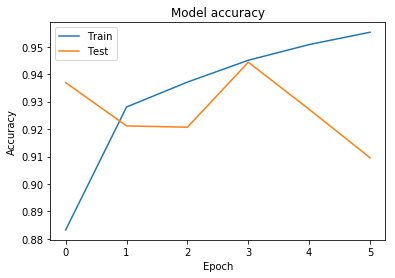

In [4]:
# Plot training & validation accuracy values
# plt.plot(history.history['categorical_accuracy']) #tf
# plt.plot(history.history['val_categorical_accuracy']) #tf
plt.plot(history.history['acc']) #keras
plt.plot(history.history['val_acc']) #keras
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


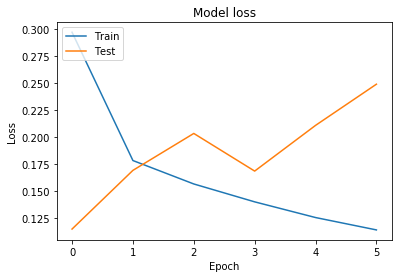

In [5]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:

# filepath='../results/data_generated1/labelled_processed_text.csv'

METRIC = "jaccard"

labelled_real=f'../analysis_jaccard/{METRIC}_labelled_real_text.csv'
labelled_fake=f'../analysis_jaccard/{METRIC}_labelled_fake_text.csv'

real_data = pd.read_csv(labelled_real)
fake_data = pd.read_csv(labelled_fake)

real_data['text'] = real_data['text'].astype('str').str.lower()
mask = (real_data['text'].str.len() >= 20)
real_data = real_data[mask]

fake_data['text'] = fake_data['text'].astype('str')
mask = (fake_data['text'].str.len() >= 20)
fake_data = fake_data[mask]

print(fake_data.head(10))

# fake_data = fake_data[len(real_data['text'].split()) >= 20]

combined_data = real_data.append(fake_data)

y = combined_data['label'].values

# file_dir = os.path.dirname(os.path.realpath('__file__'))
# filename = os.path.join(file_dir, filepath)
# filename = os.path.abspath(os.path.realpath(filename))

# data = pd.read_csv(filename)

sequences = get_sequences(max_features=5000, data=combined_data)

x = sequences # pre-processed data from step 3
print(x)
y = pd.get_dummies(combined_data['label']).values #turn sentiments into 0 and 1 into a (11538,2) matrix
print(y)

#-----Define LSTM parameters-----#
embedding_dim = 400
units = 250 #dimensionality of the output space
batch_size = 32 #Batch of sequences to process as input (fed into the .fit function)
#dropout =0.2 #float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
#recurrent_dropout=0.2 #Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.


max_len = 30 # Cuts off texts after this many words (among the max_features most common words)
epochs = 6


# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42) #random state to get same split output (42, 0, 21)
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42) #random state to get same split output (42, 0, 21)

print('input dimensions:', x.shape, '|', 'output dimensions:', y.shape)
print('x_train dimensions:', x_train.shape, '|', 'y_train dimensions:', y_train.shape)
print('x_test dimensions:', x_test.shape, '|', 'y_test dimensions:', y_test.shape)

keras_model = create_lstm_model()
history = keras_model.fit(x, y, validation_split=0.10, epochs=epochs, batch_size=batch_size, verbose=1)



   index                                               text   novelty  \
0      0  the scottish government has won and not necess...  0.718750   
1      1  the more of the main people do not to not pay ...  0.666667   
2      2  it was a shame , but when they put it up for h...  0.676471   
3      3  `` it took me , but that is a good thing , but...  0.600000   
4      4  `` i didn ' t have that a citizen of the famil...  0.666667   
5      5  we need to be , but `` that ' s just a chance ...  0.611111   
6      6  it is a better option that ' s a brexit , or m...  0.687500   
7      7  and it is ten and are not required to make it ...  0.625000   
8      8  you need to be ready , but they can draw atten...  0.687500   
9      9  `` the only thing that you are able to do anyt...  0.558824   

   diversity  label  
0   0.645161      0  
1   0.586207      0  
2   0.612903      0  
3   0.407407      0  
4   0.566667      0  
5   0.531250      0  
6   0.666667      0  
7   0.645161      0 

In [7]:
logits = keras_model.predict(x_test) 

NameError: name 'text_array' is not defined